# Paper: Wave Decay

Author: Henrique P P Pereira

- Calculate 2D Spectral using WAFO Toolbox from PNBOIA Data
- Wave data processing using WaveProc class
- Plot wave decay for RIG, FLN and SAN
- Functions to plot directional spectrum
- Interpola para 24 direcoes e 25 frequencias
- Load and plot 2d spectrum file from buoy - YYYYMMDDHHMM.DIRSPEC
- Load and plot 1d and 2d spectrum generated by WAFO MATLAB (geraspec2dpnboia.m)

In [10]:
'''
Load libraries
'''

%matplotlib inline
# %matplotlib qt

import os
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import waveproc
reload(waveproc)
from waveproc import WaveProc
import wafo as wf
import wafo.objects as wo
import scipy.io
from datetime import datetime
from scipy.interpolate import interp2d
from scipy import interpolate

In [2]:
'''
Wave data processing using WaveProc class
'''

#load WaveProc class
rig = WaveProc(os.environ['HOME'] + '/Dropbox/pnboia/dados/bruto/triaxys/pre_proc/rio_grande/hne/')
fln = WaveProc(os.environ['HOME'] + '/Dropbox/pnboia/dados/bruto/triaxys/pre_proc/florianopolis/hne/')
san = WaveProc(os.environ['HOME'] + '/Dropbox/pnboia/dados/bruto/triaxys/pre_proc/santos/hne/')

dmagrig = -17
dmagfln = -23
dmagsan = -23

#list files inside each directory
rig.listdir()
fln.listdir()
san.listdir()

#spectral parameters
fs   = 1.28
nfft = 328
h    = 200

#find files (must have all files in all the three buoys)
ini = np.where(rig.filelist == '201202010000.HNE')[0][0]
fim = np.where(rig.filelist == '201202292300.HNE')[0][0]

drig = []
dfln = []
dsan = []

for file in rig.filelist[ini:fim]:

    #read files
    rig.read_HNE(filename = file,
     		   fs         = fs,
     		   nfft       = nfft,
     		   h          = h)
    
    fln.read_HNE(filename = file,
     		   fs         = fs,
     		   nfft       = nfft,
     		   h          = h)
    
    san.read_HNE(filename = file,
     		   fs         = fs,
     		   nfft       = nfft,
     		   h          = h)
    
    if len(rig.n1) > 1000: # and np.sort(w.n1)[-100:].mean() > 0.5:

        rig.timedomain()
        fln.timedomain()
        san.timedomain()
    
        rig.freqdomain()
        fln.freqdomain()
        san.freqdomain()

        drig.append({'date'   : rig.date,
                     'hs'     : rig.hs,
                     'h10'    : rig.h10,
                     'hmax'   : rig.hmax,
                     'tmed'   : rig.tmed,
                     'thmax'  : rig.thmax,
                     'hm0'    : rig.hm0,
                     'tp'     : rig.tp,
                     'dp'     : rig.dp + dmagrig,
                     'tzamax' : rig.tzamax})

        dfln.append({'date'   : fln.date,
                     'hs'     : fln.hs,
                     'h10'    : fln.h10,
                     'hmax'   : fln.hmax,
                     'tmed'   : fln.tmed,
                     'thmax'  : fln.thmax,
                     'hm0'    : fln.hm0,
                     'tp'     : fln.tp,
                     'dp'     : fln.dp + dmagfln,
                     'tzamax' : fln.tzamax})
            
        dsan.append({'date'   : san.date,
                     'hs'     : san.hs,
                     'h10'    : san.h10,
                     'hmax'   : san.hmax,
                     'tmed'   : san.tmed,
                     'thmax'  : san.thmax,
                     'hm0'    : san.hm0,
                     'tp'     : san.tp,
                     'dp'     : san.dp + dmagsan,
                     'tzamax' : san.tzamax})
        

    else:

    	print '%s -- Reprovado' %w.date

dfrig = pd.DataFrame(drig)
dfrig = dfrig.set_index('date')

dffln = pd.DataFrame(dfln)
dffln = dffln.set_index('date')

dfsan = pd.DataFrame(dsan)
dfsan = dfsan.set_index('date')

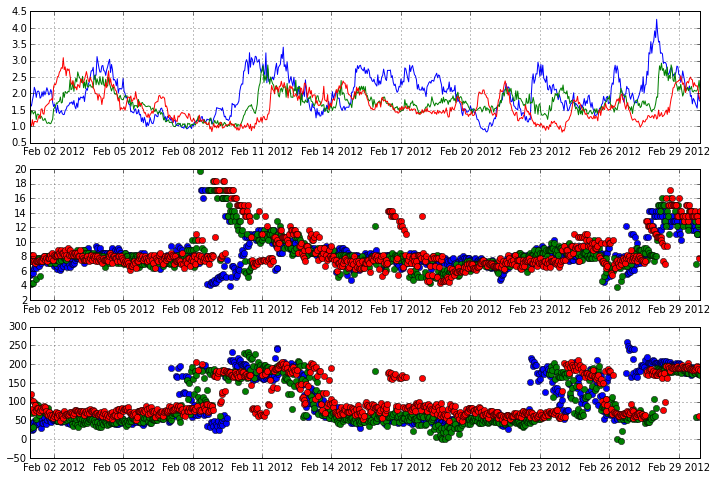

In [3]:
'''
Plot wave decay for RIG, FLN and SAN
'''

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(311)
ax1.plot(dfrig.index, dfrig.hm0,'b-', dffln.index, dffln.hm0,'g-', dfsan.index, dfsan.hm0,'r-')
ax1.grid()
# ax1.set_xlim(dfrig.index[144], dfrig.index[336])
ax2 = fig.add_subplot(312)
ax2.plot(dfrig.index, dfrig.tp,'bo', dffln.index, dffln.tp,'go', dfsan.index, dfsan.tp,'ro')
ax2.grid()
# ax2.set_xlim(dffln.index[144], dffln.index[336])
ax3 = fig.add_subplot(313)
ax3.plot(dfrig.index, dfrig.dp,'bo', dffln.index, dffln.dp,'go', dfsan.index, dfsan.dp,'ro')
ax3.grid()
# ax3.set_xlim(dfsan.index[144], dfsan.index[336])

In [4]:
'''
Functions to plot directional spectrum
'''

def plotspec1d(freq, en):
    
    '''
    1-D Spectra
    '''
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(freq, en)
    ax1.grid()
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Energy (m2/Hz)')
    ax1.set_xlim(0,0.6)   
        
def plotspec2dcart(freq, theta, sp2, date):
    
    '''
    2-D Cartestian Spectra
    '''
    
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax1.contour(freq, theta, sp2,10)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Direction (Deg)')
    ax1.set_title(str(date))
    ax1.grid()
    #ax1.set_yticks(np.arange(0,360+45,45))
    ax1.set_ylim(theta.min(),theta.max())
    ax1.set_xlim(0,0.6)

def plotspec2dpolar(freq, theta, sp2, date, proj):
    
    '''
    2-D Polar Spectra
    '''
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=proj)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    a, b = np.meshgrid(freq, theta * np.pi/180)
    ax.contourf(b, a, sp2,100) 

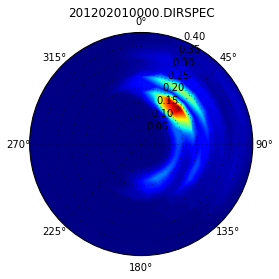

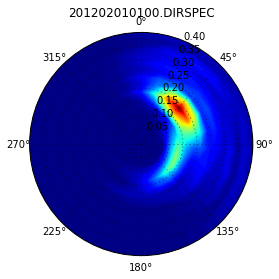

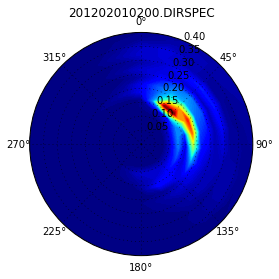

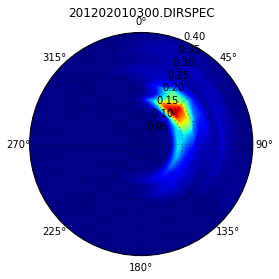

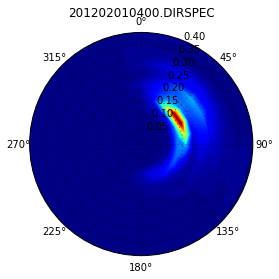

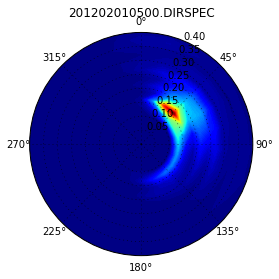

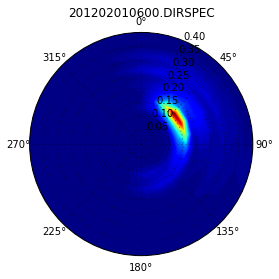

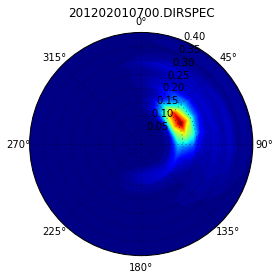

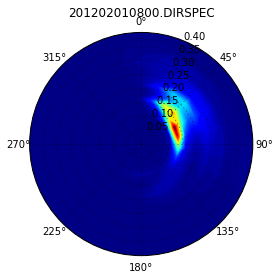

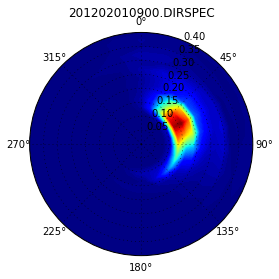

In [8]:
'''
Load and plot 2d spectrum file from buoy - YYYYMMDDHHMM.DIRSPEC
'''

pl.close('all')

pathname = os.environ['HOME'] + '/Dropbox/pnboia/dados/bruto/triaxys/pre_proc/rio_grande/2012/Feb/DIRSPEC/'
lista = np.sort(os.listdir(pathname))
date = pd.to_datetime(lista, format='%Y%m%d%H%M.DIRSPEC')
freq = np.linspace(0,0.64,129)
theta = np.linspace(0,360,121)
theta[pl.find(theta < 0)] = theta[pl.find(theta < 0)] + 360

for i in range(len(lista[0:10])):
    
    dax = pd.read_table(pathname + lista[i], skiprows=12, sep=' ', header=None)
    dax = np.array(dax.ix[:,1:]).T
    
    f = interp2d(freq, theta, dax, kind='linear')
    x = np.linspace(freq[0], freq[-1], 25)
    y = np.linspace(theta[0], theta[-1], 24)
    daxi = f(x, y)

    #plotspec2dcart(x, y, daxi, date[i])
    plotspec2dpolar(x, y, daxi, date[i], proj='polar')
    plt.title(lista[i])
    plt.ylim(0,0.4)

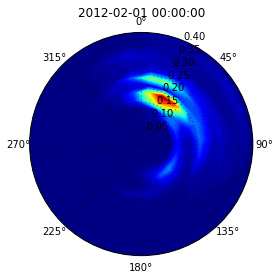

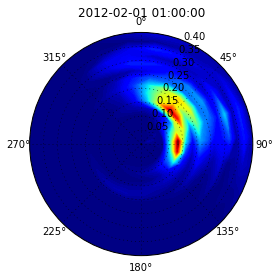

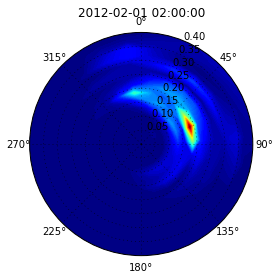

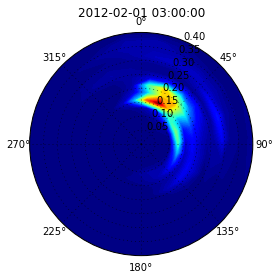

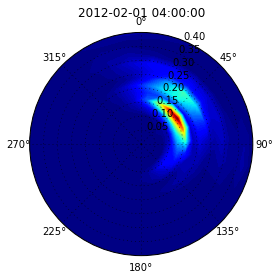

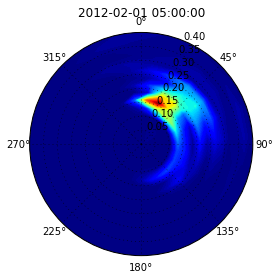

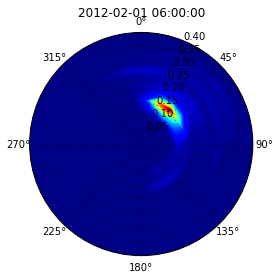

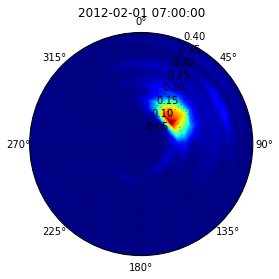

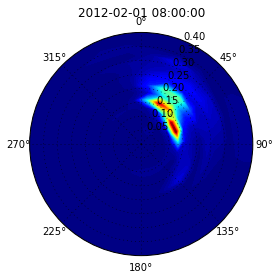

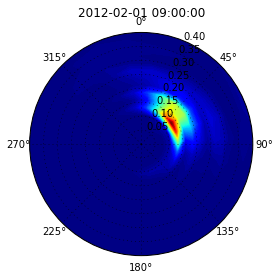

In [9]:
'''
Load and plot 1d and 2d spectrum generated by
WAFO MATLAB (geraspec2dpnboia.m)
Interpola para 24 direcoes e 25 frequencias
.mat file contain:
A.f = frequency vector
A.theta = direction vector
A.S = 2d spectrum matrix (lines=dir, columns=freq)
A.Sw = 1d spectrum
'''

mat = scipy.io.loadmat('out/spec2d/spec2d_RIG.mat')

date = pd.to_datetime(mat['A']['date'][0][0])
freq = mat['A']['f'][0][0][:,0]
theta = mat['A']['theta'][0][0][:,0] * 180/np.pi
#theta[pl.find(theta < 0)] = theta[pl.find(theta < 0)] + 360

nspec = len(mat['A']['S'][0][0])

for i in range(10):#mat['A']['S'][0][0].shape[-1]):
    
    #Directional spectrum
    DS = mat['A']['S'][0][0][:,:,i] #2D spec
    #S  = mat['A']['Sw'][0][0][:,0]  #1D spec #errado
    
    #interpolation to 25 x 24 freq
    f = interp2d(freq, theta, DS, kind='linear')
    x = np.linspace(freq[0], freq[-1], 25)
    y = np.linspace(theta[0], theta[-1], 24)
    DSi = f(x, y)

    #plotspec2dcart(x, y, DSi, date[i])
    plotspec2dpolar(x, y, DSi, date[i], proj='polar')
    plt.title(date[i])
    plt.ylim(0,0.4)